<h1 align="center">Theanets</h1>
<h4 align="center">Korepanova Natalia</h4>
<h5 align="center">Moscow, 2015</h5>

The ```theanets``` is a deep learning and neural network toolkit.

* Written in Python to iteroperate with ```numpy``` and ```scikit-learn```
* ```theano``` is used to accelerate computations when possible using GPU
* Simple API for building and training common types of neural network models
* Easy-to-read code
* Quite detailed user guide and documentation
* Under th hood, a fully expressive graph computation framework

## Installation
The easiest way is by using ```pip```:

This command will install all the dependdeces of ```theanets``` including ```numpy``` and ```theano```.

You can also download package from https://github.com/lmjohns3/theanets and run the code from your local copy:

## Package overview
Three basin steps in ```theanets```:
1. Define the structure of the model
    * Classification (```theanets.Classifier```)
    * Regression (```theanets.Regressor```)
    * Parametric mapping to the input space (```theanets.Autoencoder```)
    * Recurrent modesl (```theanets.reccurent``` module)
2. Train the model with respect to some task or cost function
3. Use the model for making predictions and/or visualizing the learned features

#### The usual sceleton of the code:

In [ ]:
import theanets

# 1. create a model -- here, a regression model.
net = theanets.Regressor([10, 100, 2])

# optional: set up additional losses.
net.add_loss('mae', weight=0.1)

# 2. train the model.
net.train(
    training_data,
    validation_data,
    algo='rmsprop',
    hidden_l1=0.01,  # apply a regularizer.
)

# 3. use the trained model.
net.predict(test_data)

-------------

## 1. Creating a Model
All network models ```theanets``` are instances of the base class ```Network``` , which maintain two pieces of information:
1. a list of layers
2. a list of (possibly regularized) loss functions

### 1.1 Specifying Layers
The easiest and the most common architecture to create is a network with a single “chain” of layers.

Example:

In [ ]:
net = theanets.Regressor(layers=[10, 20, 3])

In general, ```layers``` argument must be a sequence of values each of which specifies the configuration of a single layer in the model:

In [ ]:
net = theanets.Regressor([A, B, ..., Z])

#### Layer Attributes
* ```size```: The number of “neurons” in the layer.
* ```form```: A string specifying the type of layer to use. This defaults to “feedforward”
* ```name```: A string name for the layer. The default names for the first and last layers - 'in' and 'out', the layers in between are assigned the name “hidN” where N is the number of existing layers.
* ```activation```: A string describing the activation function to use for the layer. This defaults to 'relu' - $max(0,z)$.
* etc.

#### Activation Functions
Some possible values:
* ```relu```: $g(z) = \max(0,z)$
* ```linear```: $g(z) = z$
* ```logistic```, ```sigmoid```: $g(z) = (1 + \exp(-z))^{-1}$
* ```tanh```: $g(z) = \tanh(z)$
* ```softmax```: $g(z) = \exp(z)/\sum_v(\exp(v))$
* ```norm:z```: $g(z) = (z - \bar{z})/\mathbb{E}[(z - \bar{z})^2]$
* etc.

Activation functions can also be composed by concatenating multiple function names togather using a +.

##### Examples:

In [ ]:
net = theanets.Regressor([4, 5, 6, 2])

If there is a string in the tuple that names a registered layer type (e.g., ```'tied'```, ```'rnn'```, etc.), then this type of layer will be created.

If there is a string in the tuple and it does not name a registered layer type, the string is assumed to name an activation function—for example, ```'logistic'```, ```'relu+norm:z'```, and so on.

In [ ]:
net = theanets.Regressor([4, (5, 'sigmoid'), (6, 'softmax')])

In [ ]:
net = theanets.Regressor([10, (10, 'tanh+norm:z'), 10])

If a layer configuration value is a dictionary, its keyword arguments are passed directly to ```theanets.Layer.build()``` to construct a new layer instance. The dictionary must contain a ```size``` key. It can additionally contain any other keyword arguments that you wish to use when constructing the layer.

In [ ]:
net = theanets.Regressor([4, dict(size=5, activation='tanh'), 2])

In [ ]:
net = theanets.Regressor([4, dict(size=5, sparsity=0.9), 2])

```sparsity```: A float giving the proportion of parameter values in the layer that should be initialized to zero. Nonzero values in the parameters will be drawn from a Gaussian distribution and then an appropriate number of these parameter values will randomly be reset to zero to make the parameter “sparse.”

#### Custom Layers
To create a custom layer, just create a subclass of ```theanets.Layer``` and give it the functionality you want.

An example of a normal feedforward layer but without a bias term:

In [ ]:
import theanets
import theano.tensor as TT

class NoBias(theanets.Layer):
    # Transform the inputs for this layer into an output for the layer.
    def transform(self, inputs):
        return TT.dot(inputs, self.find('w'))
    
    #Helper method to create a new weight matrix.
    def setup(self):
        self.add_weights('w', nin=self.input_size, nout=self.size)
        

layer = theanets.Layer.build('nobias', size=4)
net = theanets.Autoencoder(layers=[4, (3, 'nobias', 'linear'), (4, 'tied', 'linear')])

### 1.2 Specifying a Loss
All of the predefined models in ```theanets``` are created by default with one loss function appropriate for that type of model.
* ```Autoencoder```: MSE between network's output and input
$$\mathcal{L}(X,\theta) = \frac{1}{mn}\sum_{i=1}^m\|F_\theta(x_i)-x_i\|_2^2, \quad X \in \mathbb{R}^{m\times n}$$
* ```Regressor```: MSE between true and predicted values of the target
$$\mathcal{L}(X, Y,\theta) = \frac{1}{mn}\sum_{i=1}^m\|F_\theta(x_i)-y_i\|_2^2, \quad X \in \mathbb{R}^{m\times n}, Y \in \mathbb{R}^{m\times o}$$
* ```Classifier```: Cross-entropy between the network output and the true target labels
$$\mathcal{L}(X, Y,\theta) = \frac{1}{m}\sum_{i=1}^m \sum_{j=1}^{k}\delta_{j, y_i}\log F_\theta(x_i)_j, \quad X \in \mathbb{R}^{m\times n}, Y \in \{1,...,k\}^m$$

For example, to use a mean-absolute error instead of the default mean-squared error for a regression model:

In [ ]:
net = theanets.Regressor([4, 5, 2], loss='mae')

#### Multiple Loss
Let’s say that you want to optimize a model using both the mean absolute and the mean squared error. You could first create a regular regression model:

In [ ]:
net = theanets.Regressor([10, 20, 3])
net.add_loss('mae', weight=0.1)

You can specify the relative weight of the two losses by manipulating the ```weight``` attribute of each loss instance. For instance, if you want the MAE loss to be twice as strong as the MSE loss:

In [ ]:
net.losses[1].weight = 2

#### Weighted Targets
Include ```weighted=True``` when you create a model. Example:

In [ ]:
net = theanets.recurrent.Autoencoder([3, (10, 'rnn'), 3], weighted=True)

The training and validation datasets require an additional component: an array of floating-point values with the same shape as the expected output of the model, so that the training and validation datasets would each have three pieces: ```sample```, ```label```, and ```weight```. Each value in the weight array is used as the weight for the corresponding error when computing the loss.

#### Custom Losses
Create a new ```theanets.Loss``` subclass and specify its name when you create your model.

For example, to create a regression model that uses a step function averaged over all of the model inputs with weighted outputs:

In [ ]:
class Step(theanets.Loss):
    def __call__(self, outputs):
        step = outputs[self.output_name] > 0
        if self._weights:
            return (self._weights * step).sum() / self._weights.sum()
        else:
            return step.mean()

net = theanets.Regressor([5, 6, 7], loss='step', weighted=True)

### 1.3 Recurrent Models


Time is an explicit part of the model:
* all the data shapes are one dimension larger than the corresponding shapes for a feedforward network
* the extra dimension represents time
* the extra dimension is located on:
    * the first (0) axis in theanets versions through 0.6
    * the second (1) axis in theanets versions 0.7 and up.



Recurrent versions of the three types of models:
* ```theanets.recurrent.Autoencoder```: takes as input $X \in \mathbb{R}^{m\times t \times n}$ and recreates the same data at the output under squared-error loss
* ```theanets.recurrent.Regressor```: input data $X \in \mathbb{R}^{m\times t \times n}$ and output data $Y \in \mathbb{R}^{m\times t \times o}$, fit the output under squared-error loss
* ```theanets.recurrent.Classifier```: input data $X \in \mathbb{R}^{m\times t \times n}$ and set of integer labels $Y \in \mathbb{Z}^{m \times t}$, the default  error is cross-enthropy

### 1.4 Custom Models
To create a custom model, just define a new subclass of ```theanets.Network```.

For instance, the feedforward autoencoder model is defined basically like this:

In [ ]:
class Autoencoder(theanets.Network):
    def __init__(self, layers=(), loss='mse', weighted=False):
        super(Autoencoder, self).__init__(
            layers=layers, loss=loss, weighted=weighted)

------

## 2. Training a Model
### 2.1 Specifying a Trainer
The easiest way train a model with theanets is to invoke the ```train()``` method:

In [ ]:
net = theanets.Classifier(layers=[10, 5, 2])
net.train(training_data,
          validation_data,
          algo='nag',
          learning_rate=0.01,
          momentum=0.9)

Here, a classifier model is being trained using Nesterov’s accelerated gradient, with a learning rate of 0.01 and momentum of 0.9.

Multiple calls to ```train()``` are possible and can be used to implement things like custom annealing schedules (e.g., the “newbob” training strategy):

In [ ]:
net = theanets.Classifier(layers=[10, 5, 2])

for e in (-2, -3, -4):
    net.train(training_data,
              validation_data,
              algo='nag',
              learning_rate=10 ** e,
              momentum=1 - 10 ** (e + 1))

#### Trainers
In ```theanets``` the most of the trainers are provided by ```downhill``` package which provides algorithms for minimizing scalar loss functions that are defined using ```theano```.
* ```sgd```: Stochastic gradient descent
* ```nag```: Nesterov’s accelerated gradient
* ```rprop```: Resilient backpropagation
* ```rmsprop```: RMSProp
* ```adadelta```: ADADELTA
* ```esgd```: Equilibrated SGD
* ```adam```: Adam

Also ```theanets``` defines a few algorithms which are more specific to neural networks:
* ```sampler```: This trainer sets model parameters directly to samples drawn from the training data. This is a very fast “training” algorithm since all updates take place at once; however, often features derived directly from the training data require further tuning to perform well.
* ```layerwise```: Greedy supervised layerwise pre-training: This trainer applies RMSProp to each layer sequentially.
* ```pretrain```: Greedy unsupervised layerwise pre-training: This trainer applies RMSProp to a tied-weights “shadow” autoencoder using an unlabeled dataset, and then transfers the learned autoencoder weights to the model being trained.

### 2.2 Providing Data
There are two ways of passing data: using ```numpy``` arrays and callables.

Instead of an array of data, you can provide a callable for a Dataset. This callable must take no arguments and must return a list of numpy arrays of the proper shape for your loss.

For example, this code defines a ```batch()``` helper that could be used for a loss that needs one input. The callable chooses a random dataset and a random offset for each batch:

In [ ]:
SOURCES = 'foo.npy', 'bar.npy', 'baz.npy'
BATCH_SIZE = 64

def batch():
    X = np.load(np.random.choice(SOURCES), mmap_mode='r')
    i = np.random.randint(len(X))
    return X[i:i+BATCH_SIZE]

net = theanets.Regressor(layers=[10, 5, 2])
net.train(train=batch, ...)

### 2.3 Specifying Regularizers
Regularizers in theanets are specified during training, in calls to ```Network.train()```, or during use, in calls to ```Network.predict()```.
#### Built-in Regularizers
* Decay: $$\mathcal{L}(\cdot)=...+\lambda\|\theta\|_2^2$$
* Sparcity: $$\mathcal{L}(\cdot)=...+\lambda\|\theta\|_1$$
* Hidden representations: $$\mathcal{L}(\cdot)=...+\lambda \sum_{i=2}^{N-1}\|f_i(x)\|_1$$
where $f_i(x)$ - activation function of i-th hidden layer
* Zero-mean Gaussian noise is added to input data or hidden layers
* Multiplicative dropout (binary) noise set some inputs or hidden layers parameters to zero


In [ ]:
net.train(..., weight_l2=1e-4) # Decay
net.train(..., weight_l1=1e-4) # Sparcity
net.train(..., hidden_l1=0.1) # Hidden representations
net.train(..., input_noise=0.1) # Zero-mean Gaussian noise with std=0.1 added to the input
net.train(..., hidden_noise=0.1) # Zero-mean Gaussian noise with std=0.1 added to the hidden layers
net.train(..., input_dropout=0.3) # Binary noise with 0.3 probability of being set to zero added to the inputs
net.train(..., hidden_dropout=0.3) # Binary noise with 0.3 probability of being set to zero added
                                   # to the hidden paraeters

#### Custom Regularizers
To create a custom regularizer in theanets, you need to create a custom subclass of the ```theanets.Regularizer``` class, and then provide this regularizer when you run your model.

Example:

In [ ]:
class WeightInverse(theanets.Regularizer):
    def loss(self, layers, outputs):
        return sum((1 / (p * p).sum(axis=0)).sum()
                   for l in layers for p in l.params
                   if p.ndim == 2)

net = theanets.Autoencoder([4, (8, 'linear'), (4, 'tied')])
net.train(..., weightinverse=0.001)

### 2.4 Training as Iteration

In [ ]:
for train, valid in net.itertrain(train_data, valid_data, **kwargs):
    print('training loss:', train['loss'])
    print('most recent validation loss:', valid['loss'])

### 2.5 Saving Progress
The ```theanets.Network``` base class can snapshot your model automatically during training. When you call ```theanets.Network.train()```, you can provide the following keyword arguments:

* ```save_progress```: a string containing a filename where the model should be saved
    * include an empty format string {} to format filename with the UTC Unix timestamp at the moment the model is saved.
* ```save_every```: a numeric value specifying how often the model should be saved during training
    * integer value: the number of training iterations between checkpoints
    * float value: the number of minutes that are allowed to elapse between checkpoints.

Mannualy:
* ```theanets.Network.save()```
* ```theanets.Network.load()```

-------

## 3. Using a Model
### 3.1 Predicting New Data

In [ ]:
results = net.predict(new_dataset)

Regardless of the model, you pass to ```predict()``` a ```numpy``` array containing data examples along the rows, and the method returns an array containing one row of output predictions for each row of input data.

You can also compute the activations of all layer outputs in the network using the ```theanets.Network.feed_forward()``` method:

In [ ]:
for name, value in net.feed_forward(new_dataset).items():
    print(abs(value).sum(axis=1))

This method returns a dictionary that maps layer output names to their corresponding values for the given input. Like ```predict()```, each output array contains one row for every row of input data.

### 3.2 Inspecting Parameters
The parameters in each layer of the model are available using ```theanets.Network.find()```. The first query term finds a layer in the network, and the second finds a parameter within that layer.

The ```find()``` method returns a ```theano``` shared variable. To get a ```numpy``` array of the current values of the variable, call ```get_value()``` on the result from ```find()```, like so:

In [ ]:
param = net.find('hid1', 'w')
values = param.get_value()

-----------

## Computation Graphs
In ```theanets``` it is also possible to create network graphs that have arbitrary, acyclic connections among layers. Creating a nonlinear network graph requires using the inputs keyword argument when creating a layer.


In [ ]:
theanets.Classifier((
    784,
    dict(size=100, name='a'),
    dict(size=100, name='b'),
    dict(size=100, name='c'),
    dict(size=10, inputs=('a', 'b', 'c')),
))

-------

## Examples

In [1]:
import theanets
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
mnist = np.loadtxt("/home/natalia/ML/mnist_train.csv", delimiter=",", skiprows=1)

In [3]:
train_X = (mnist[:30000, 1:]/255.).astype('f')
train_y = mnist[:30000, 0].astype('i')
valid_X = (mnist[30000:, 1:]/255.).astype('f')
valid_y = mnist[30000:, 0].astype('i')
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(30000, 784) (30000,) (12000, 784) (12000,)


### MNIST Autoencoder (PCA)

Many extremely common dimensionality reduction techniques can be expressed as autoencoders. For instance, Principal Component Analysis (PCA) can be expressed as a model with two tied, linear layers:

In [4]:
pca = theanets.Autoencoder([784, (10, 'linear'), (784, 'tied')])
pca.train(train_X, valid_X)

(OrderedDict([('loss', 0.036098549547374022), ('err', 0.036098549547374022)]),
 OrderedDict([('loss', 0.035916419064936603), ('err', 0.035916419064936603)]))

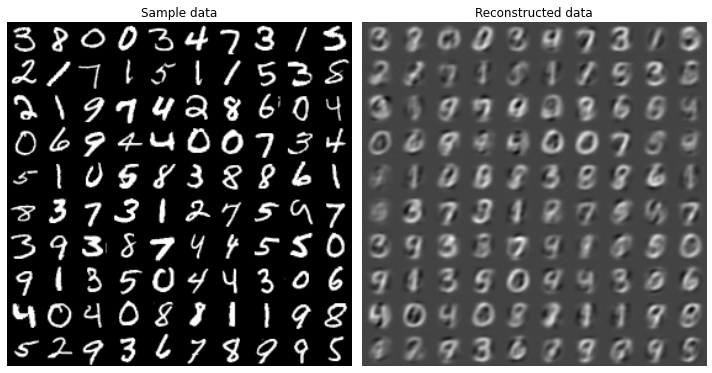

In [5]:
from utils import plot_images # from https://github.com/lmjohns3/theanets/tree/master/examples

v = valid_X[:100,:]

plt.figure(figsize = (10,10))
plot_images(v, 121, 'Sample data')
plt.tight_layout()
plot_images(pca.predict(v), 122, 'Reconstructed data')
plt.tight_layout()
plt.show()

### MNIST Classifier

In [20]:
net = theanets.Classifier(layers=[784, 100, 10])

In [6]:
train = [train_X, train_y]
valid = [valid_X, valid_y]
net.train(train, valid, algo='nag', learning_rate=1e-3, momentum=0.9)

(OrderedDict([('loss', 0.013065119550365448),
              ('err', 0.013065119550365448),
              ('acc', 0.99926705756929635)]),
 OrderedDict([('loss', 0.10607663874755013),
              ('err', 0.10607663874755013),
              ('acc', 0.96950000000000003)]))

In this example, the weights in layer 1 connect the inputs to the first hidden layer; these weights have one column of 784 values for each hidden node in the network, so we can iterate over the transpose and put each column—properly reshaped—into a giant image.

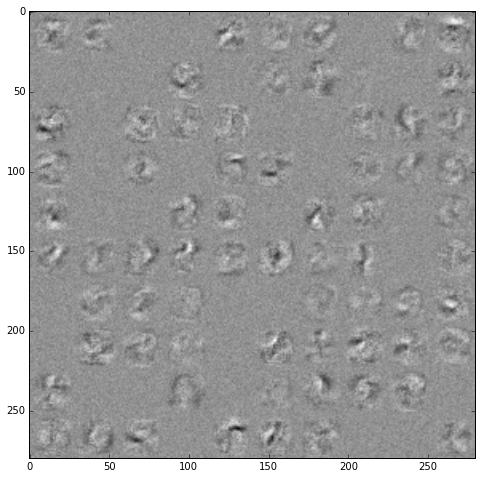

In [7]:
img = np.zeros((28 * 10, 28 * 10), dtype='f')
plt.figure(figsize = (8,8))
for i, pix in enumerate(net.find('hid1', 'w').get_value().T):
    r, c = divmod(i, 10)
    img[r * 28:(r+1) * 28, c * 28:(c+1) * 28] = pix.reshape((28, 28))
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [8]:
net.train(train, valid, algo='nag', learning_rate=1e-3, momentum=0.9, weight_l1=1e-4)

(OrderedDict([('loss', 0.013084627115735412),
              ('err', 0.013066478880275028),
              ('acc', 0.9992337420042644)]),
 OrderedDict([('loss', 0.10631991185110473),
              ('err', 0.10630197285552036),
              ('acc', 0.96933333333333338)]))

In [26]:
for train, valid in net.itertrain([train_X, train_y], [valid_X, valid_y], algo='sgd',
                                  learning_rate=1e-2, momentum=0.9, min_improvement=0.1, patience=1):
    print('training loss:', train['loss'])
    print('most recent validation loss:', valid['loss'])

training loss: 0.0131436083486
most recent validation loss: 0.100858014636
training loss: 0.0123885964367
most recent validation loss: 0.100858014636
training loss: 0.010871690627
most recent validation loss: 0.100858014636
training loss: 0.0100087594541
most recent validation loss: 0.100858014636
training loss: 0.00886277772078
most recent validation loss: 0.100858014636
training loss: 0.00816914070567
most recent validation loss: 0.100858014636
training loss: 0.00753012226999
most recent validation loss: 0.100858014636
training loss: 0.00693038771402
most recent validation loss: 0.100858014636
training loss: 0.00628071532663
most recent validation loss: 0.100858014636
training loss: 0.0060689916495
most recent validation loss: 0.100858014636
training loss: 0.00550500847408
most recent validation loss: 0.107343682464
training loss: 0.00526325625259
most recent validation loss: 0.107343682464
training loss: 0.0049138985603
most recent validation loss: 0.107343682464
training loss: 0.00